# Regression

### Import libraries and set seeds

In [1]:
import os, math, random, gc
from pathlib import Path
from typing import List, Optional, Dict, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8"

import torch
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


# -------------------- Reproducibility --------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = Path("models_final") 
RESULTS_DIR = Path("results_final")

# Text Preprocessing

In [2]:
def _safe_str(x) -> str:     # Returns an empty string in case of None or Nan values
    if x is None: 
        return ""
    if isinstance(x, float) and np.isnan(x): 
        return ""
    return str(x)

def compose_3cols(row, sep=" "):   # Concatenate title + description + transcript
    parts = [
        _safe_str(row.get("title", "")).strip(),
        _safe_str(row.get("description", "")).strip(),
        _safe_str(row.get("transcript", "") or row.get("transcript_text", "")).strip(),
    ]
    parts = [p for p in parts if p]
    return sep.join(parts) if parts else ""

# Dataset Class

In [3]:
class BertRegDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, target_col: str, max_len: int = 256):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer                # Autotokenzier in our case
        self.max_len = max_len              # fixed padded/truncated sequence length
        self.target_col = target_col

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]      # Get the row at idx index
        text = compose_3cols(row)    # Compose the final text by concatenating the 3 columns
        # Tokenize to fixed length, returning PyTorch tensors
        enc = self.tok(
            text,
            truncation=True,         # Cut longer texts to max_length
            padding="max_length",    # Pad shorter texts to max_length
            max_length=self.max_len,
            return_tensors="pt"      # Return torch tensors
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),      # LongTensor [L]
            "attention_mask": enc["attention_mask"].squeeze(0),   # LongTensor [L]
            "labels": torch.tensor(float(row[self.target_col]), dtype=torch.float32)   # FloatTensor scalar (regression)
        }

# Prediction Model

In [4]:
class AttnPooler(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.W = nn.Linear(hidden_size, hidden_size)   # projects token vectors before scoring
        self.v = nn.Linear(hidden_size, 1, bias=False)  # score vector (v^T * tanh(W h_t))
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor):
        # hidden_states: (B,T,H) ; attention_mask: (B,T) with 1 for real tokens, 0 for padding
        H = torch.tanh(self.W(hidden_states))         # (B, T, H) nonlinearity before scoring
        logits = self.v(H).squeeze(-1)                # (B, T) raw attention scores per token
        logits = logits.masked_fill(attention_mask == 0, -1e9) # Mask out pads so they get ~0 probability after softmax
        a = torch.softmax(logits, dim=1)              # (B, T) normalized attention weights
        return torch.bmm(a.unsqueeze(1), hidden_states).squeeze(1)  # Weighted sum over time: (B, 1, T) @ (B, T, H) -> (B, 1, H) -> (B, H)

class BertRegressor(nn.Module):
    def __init__(self, bert_name: str = "bert-base-uncased", dropout: float = 0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_name)  # HF model (returns BaseModelOutput)
        H = self.bert.config.hidden_size      # hidden width (768 for base)
        self.pool = AttnPooler(H)                    # attention pooling over tokens
        self.head = nn.Sequential(                   # regression head
            nn.Dropout(dropout),
            nn.Linear(H, 1)
        )

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask) # Forward through BERT; we only need the last hidden states (B, T, H)
        last_hidden = out.last_hidden_state          # (B,T,H)
        pooled = self.pool(last_hidden, attention_mask) # Pool token representations using attention (masking pads) - (B, H)
        logits = self.head(pooled).squeeze(-1)       # Map to scalar regression target - (B,)
        return logits

# Training Loop

In [5]:
def _safe_pc(x, y, eps=1e-8):
    x = np.asarray(x, dtype=np.float64)    # Ensure arrays
    y = np.asarray(y, dtype=np.float64)
    if x.std() < eps or y.std() < eps:   # Avoid div-by-zero
        return 0.0
    return float(np.corrcoef(x, y)[0,1])   # Pearson r

@torch.no_grad()
def eval_regression(model, loader):
    model.eval()    # Set model to eval mode
    preds, tgts = [], []
    for batch in loader:
        ids  = batch["input_ids"].to(DEVICE)   # Move the token ids (B, T) to device
        mask = batch["attention_mask"].to(DEVICE)   # Move the attention mask (B, T) to device
        y    = batch["labels"].to(DEVICE)     # Targets (B,) to device
        yhat = model(ids, mask)      # Forward pass - predictions (B,)
        preds.append(yhat.cpu().numpy())    # stash predictions on CPU
        tgts.append(y.cpu().numpy())        # stash targets on CPU
    yhat = np.concatenate(preds)       # Get all predictions - (N, )
    ytgt = np.concatenate(tgts)        # Get all targets (N, )
    mse = float(mean_squared_error(ytgt, yhat))
    pc  = _safe_pc(yhat, ytgt)
    return mse, pc, yhat, ytgt

In [6]:
def train_bert_regression(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    target_col: str = "log_view_count",
    max_len: int = 256,
    epochs: int = 8,
    batch_size: int = 16,
    lr: float = 2e-5,
    weight_decay: float = 0.01,
    warmup_ratio: float = 0.1,
    dropout: float = 0.1,
    huber_delta: float = 1.0,
    early_stop_patience: int = 10,
    seed: int = 42,
):
    set_seed(seed)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)  # Hugging Face tokenizer

    # Build HF-style datasets (each item: input_ids, attention_mask, labels)
    ds_tr = BertRegDataset(train_df, tokenizer, target_col=target_col, max_len=max_len)
    ds_va = BertRegDataset(val_df,   tokenizer, target_col=target_col, max_len=max_len)

    g = torch.Generator(device="cpu").manual_seed(int(seed))
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, generator=g,  num_workers=0  # Seeded shuffle
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, generator=g, num_workers=0) # No shuffle

    # Model: BERT backbone + attention pooling + linear head
    model = BertRegressor(bert_name="bert-base-uncased", dropout=dropout).to(DEVICE)

    criterion = nn.HuberLoss(delta=huber_delta)   # Huber loss - Robust to outliers
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay) # Adam optimizer

    total_steps  = epochs * max(1, len(dl_tr))    # total optimizer steps
    warmup_steps = int(warmup_ratio * total_steps)    # warmup steps
    scheduler    = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)  # linear warmup/decay

    # early stopping trackers
    best_val = float("inf") 
    best_state = None 
    bad = 0

    for ep in range(1, epochs + 1):
        model.train()         # training mode
        for batch in dl_tr:
            ids  = batch["input_ids"].to(DEVICE)        # (B, T)
            mask = batch["attention_mask"].to(DEVICE)   # (B, T)
            y    = batch["labels"].to(DEVICE)           # (B,)

            yhat = model(ids, mask)            # (B,)
            loss = criterion(yhat, y)          # scalar loss

            optimizer.zero_grad()            # reset gradients
            loss.backward()                # backpropagation
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # gradient clipping for stability
            optimizer.step()     # update weights
            scheduler.step()     # LR schedule step-per-optimizer-step

        # Epoch metrics on train/val (no-grad)
        tr_mse, tr_pc, _, _ = eval_regression(model, dl_tr)
        va_mse, va_pc, _, _ = eval_regression(model, dl_va)
        print(f"Epoch {ep:02d} | Train MSE {tr_mse:.4f}  PC {tr_pc:.3f} | Val MSE {va_mse:.4f}  PC {va_pc:.3f}")

        # Early stopping on validation MSE (with tiny tolerance)
        if va_mse < best_val - 1e-9:
            best_val = va_mse
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()} # store a CPU copy of the state_dict (robust to later .to(device) changes)
            bad = 0
        else:
            bad += 1
            if bad >= early_stop_patience:
                print("Early stopping.")
                break

    # Restore best checkpoint (if found)
    if best_state is not None:
        model.load_state_dict(best_state)

    # Final metrics (true)
    tr_mse, tr_pc, _, _ = eval_regression(model, dl_tr)
    va_mse, va_pc, _, _ = eval_regression(model, dl_va)
    metrics = {"train_mse": tr_mse, "train_pc": tr_pc, "val_mse": va_mse, "val_pc": va_pc}
    return model, tokenizer, metrics

# Optuna for Hyperparameter Tuning

In [7]:
import optuna

def tune_bert_regression_optuna(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    tag: str,
    target_col: str = "log_view_count",
    n_trials: int = 15,
    seed: int = 42,
    max_len: str = 256,
    epochs_choices: int =30):

    set_seed(seed)
    sampler = optuna.samplers.TPESampler(seed=seed)   # For reproducibility
    study = optuna.create_study(direction="minimize", sampler=sampler)  # Create study to minimize the MSE

    def objective(trial: optuna.trial.Trial):
        params = dict(
            lr            = trial.suggest_float("lr", 1e-5, 5e-5, log=True),   # Suggest any float between the given range  sampled log uniformly
            weight_decay  = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True), # Suggest any float between the given range  sampled log uniformly
            warmup_ratio  = trial.suggest_float("warmup_ratio", 0.0, 0.2),    # Suggest any float between the given range
            dropout       = trial.suggest_float("dropout", 0.05, 0.4),       # Suggest any float between the given range
            huber_delta   = trial.suggest_float("huber_delta", 0.5, 2.0)     # Suggest any float between the given range
        )

        # Train the model and get the model, tokens and metrics
        model, tok, mets = train_bert_regression(
            train_df=train_df, val_df=val_df, target_col=target_col,
            max_len=max_len, epochs=30,
            lr=params["lr"], weight_decay=params["weight_decay"], warmup_ratio=params["warmup_ratio"],
            dropout=params["dropout"], huber_delta=params["huber_delta"],
            seed=seed,
        )
        val_mse = float(mets["val_mse"])   # Retrieve the validation MSE

        # cleanup GPU between trials
        del model, tok
        if torch.cuda.is_available():    # Free CUDA cache
            torch.cuda.empty_cache()     
        gc.collect()                # Free Python objects
        return val_mse

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    print("Best val MSE:", study.best_value)
    print("Best params:", study.best_params)

    # retrain once with best params and return
    p = study.best_params
    best_model, best_tok, best_metrics = train_bert_regression(
        train_df=train_df, val_df=val_df, target_col=target_col,
        max_len=max_len, epochs=30,
        lr=p["lr"], weight_decay=p["weight_decay"], warmup_ratio=p["warmup_ratio"],
        dropout=p["dropout"], huber_delta=p["huber_delta"],
        early_stop_patience=10, seed=seed,
    )

    # Evaluate on validation again to export predictions
    g = torch.Generator(device="cpu").manual_seed(int(seed))
    ds_va = BertRegDataset(val_df, best_tok, target_col=target_col, max_len=max_len)
    dl_va = DataLoader(ds_va, batch_size=16, shuffle=False, generator=g, num_workers=0)
    _, _, y_pred, y_true = eval_regression(best_model, dl_va)
    video_ids = val_df["video_id"].to_numpy()

    pt_path  = MODEL_DIR / f"text_reg_{tag}.pt"
    pkl_path = MODEL_DIR / f"text_reg_{tag}.pkl"
    csv_path = RESULTS_DIR / f"text_reg_val_{tag}.csv"

    torch.save(best_model.state_dict(), pt_path) # Save the best model

    # Save the bundle
    bundle = {
        "model_class": "BertRegressor",
        "encoder_model": "bert-base-uncased",
        "pooling": "attn",
        "head": "linear",
        "state_dict": {k: v.detach().cpu().numpy() for k, v in best_model.state_dict().items()},
        "tokenizer_name": "bert-base-uncased",
        "hyperparams": {
            **p,
            "target_col": target_col,
            "seed": seed,
        },
        "metrics": {k: float(v) for k, v in best_metrics.items()},
        "version": {"torch": torch.__version__},
    }
    with open(pkl_path, "wb") as f:
        pickle.dump(bundle, f)

    # CSV — validation predictions
    df_val_out = pd.DataFrame({
        "video_id": video_ids,
        "y_true": y_true.astype(float),
        "y_pred": y_pred.astype(float),
    })
    df_val_out.to_csv(csv_path, index=False)

    # Plot true vs predictions scatterplot
    lo = float(min(y_true.min(), y_pred.min()))
    hi = float(max(y_true.max(), y_pred.max()))
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=10, alpha=0.6)
    plt.plot([lo, hi], [lo, hi], linestyle="--")
    plt.xlabel("True (log_view_count)")
    plt.ylabel("Predicted (log_view_count)")
    plt.title(f"BERT Text Regression — Val ({tag})\nMSE={best_metrics['val_mse']:.4f}, PC={best_metrics['val_pc']:.4f}")
    plt.tight_layout()

    print(f"[Saved]\n  {pt_path}\n  {pkl_path}\n  {csv_path}")

    return study, best_model, best_tok, best_metrics, study.best_params

# Person-Independent Split

[I 2025-08-15 21:18:48,991] A new study created in memory with name: no-name-a9e1ad10-1a29-4706-8e87-0eec5c9b2034


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 01 | Train MSE 103.1542  PC 0.248 | Val MSE 74.9486  PC 0.070
Epoch 02 | Train MSE 58.0589  PC 0.254 | Val MSE 40.4490  PC -0.037
Epoch 03 | Train MSE 21.0429  PC 0.160 | Val MSE 15.3930  PC 0.030
Epoch 04 | Train MSE 16.3417  PC 0.170 | Val MSE 14.2660  PC 0.025
Epoch 05 | Train MSE 15.4896  PC 0.269 | Val MSE 14.6950  PC -0.046
Epoch 06 | Train MSE 15.1717  PC 0.338 | Val MSE 14.8597  PC -0.135
Epoch 07 | Train MSE 14.1770  PC 0.401 | Val MSE 15.5230  PC -0.149
Epoch 08 | Train MSE 13.4942  PC 0.522 | Val MSE 13.5346  PC 0.189
Epoch 09 | Train MSE 11.7224  PC 0.573 | Val MSE 16.4421  PC -0.127
Epoch 10 | Train MSE 10.6879  PC 0.668 | Val MSE 15.1062  PC 0.060
Epoch 11 | Train MSE 9.7715  PC 0.714 | Val MSE 14.1916  PC 0.152
Epoch 12 | Train MSE 9.1737  PC 0.715 | Val MSE 16.0042  PC 0.018
Epoch 13 | Train MSE 8.5825  PC 0.743 | Val MSE 15.9376  PC 0.031
Epoch 14 | Train MSE 8.2331  PC 0.754 | Val MSE 14.8878  PC 0.208
Epoch 15 | Train MSE 7.8597  PC 0.781 | Val MSE 15.1859  PC 

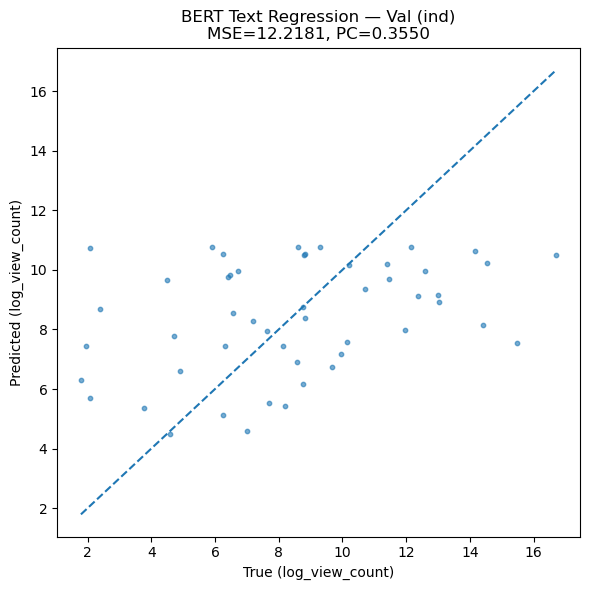

In [8]:
# -------------------- Example (uncomment to run) --------------------
df = pd.read_csv("FinalDataset.csv")

train_ids = set(os.listdir("Person-Independent_Split/train"))
val_ids   = set(os.listdir("Person-Independent_Split/val"))

train_df  = df[df.video_id.isin(train_ids)].reset_index(drop=True)
val_df    = df[df.video_id.isin(val_ids)].reset_index(drop=True)

study, best_model, best_tok, best_mets, best_params = tune_bert_regression_optuna(
    train_df, val_df, target_col="log_view_count",
    n_trials=15, seed=42,
    max_len = 256, tag="ind"
)
print(best_mets, best_params)

In [9]:
print("Person-Independent Split:")
print(f"Best Val MSE:" , {best_mets['val_mse']})
print(f"Best Val PC:", {best_mets['val_pc']})

Person-Independent Split:
Best Val MSE: {12.2180814743042}
Best Val PC: {0.35498744632078705}


# Person-Dependent Split

[I 2025-08-15 22:26:47,051] A new study created in memory with name: no-name-dc75b686-93a5-4ac1-b41c-7e52e2fce53e


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 01 | Train MSE 100.6123  PC 0.229 | Val MSE 95.9736  PC 0.448
Epoch 02 | Train MSE 56.5775  PC 0.242 | Val MSE 52.8507  PC 0.348
Epoch 03 | Train MSE 21.5193  PC 0.219 | Val MSE 22.6215  PC 0.169
Epoch 04 | Train MSE 17.5201  PC 0.241 | Val MSE 19.8542  PC 0.201
Epoch 05 | Train MSE 16.7737  PC 0.277 | Val MSE 19.6785  PC 0.172
Epoch 06 | Train MSE 16.2577  PC 0.305 | Val MSE 19.7150  PC 0.180
Epoch 07 | Train MSE 15.6675  PC 0.360 | Val MSE 19.5950  PC 0.184
Epoch 08 | Train MSE 15.0172  PC 0.404 | Val MSE 19.2583  PC 0.233
Epoch 09 | Train MSE 14.1439  PC 0.476 | Val MSE 18.7749  PC 0.288
Epoch 10 | Train MSE 12.8431  PC 0.567 | Val MSE 17.4370  PC 0.413
Epoch 11 | Train MSE 12.2493  PC 0.594 | Val MSE 17.5230  PC 0.379
Epoch 12 | Train MSE 10.3777  PC 0.733 | Val MSE 14.8249  PC 0.553
Epoch 13 | Train MSE 9.2924  PC 0.808 | Val MSE 14.3825  PC 0.603
Epoch 14 | Train MSE 8.8529  PC 0.775 | Val MSE 14.8501  PC 0.571
Epoch 15 | Train MSE 7.5277  PC 0.836 | Val MSE 14.1895  PC 0.5

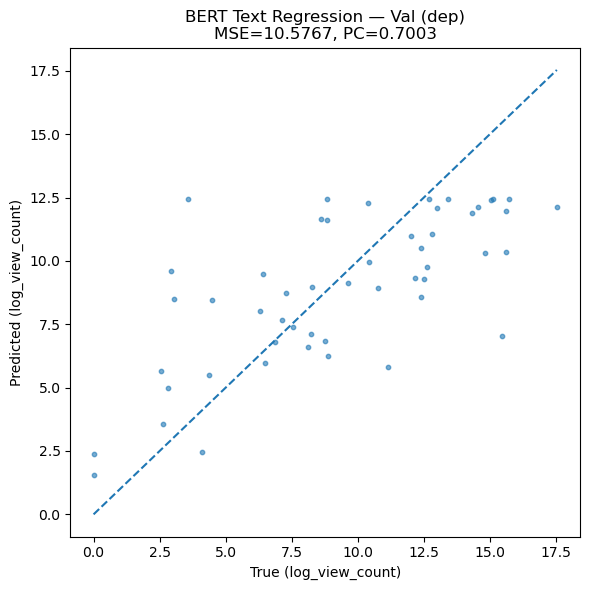

In [10]:
# -------------------- Example (uncomment to run) --------------------
df = pd.read_csv("FinalDataset.csv")

train_ids = set(os.listdir("Person-Dependent_Split/train"))
val_ids   = set(os.listdir("Person-Dependent_Split/val"))

train_df  = df[df.video_id.isin(train_ids)].reset_index(drop=True)
val_df    = df[df.video_id.isin(val_ids)].reset_index(drop=True)

study, best_model, best_tok, best_mets, best_params = tune_bert_regression_optuna(
    train_df, val_df, target_col="log_view_count",
    n_trials=15, seed=42,
    max_len=256, tag="dep"
)
print(best_mets, best_params)

In [11]:
print("Person-Dependent Split:")
print(f"Best Val MSE:" , {best_mets['val_mse']})
print(f"Best Val PC:", {best_mets['val_pc']})

Person-Dependent Split:
Best Val MSE: {10.576708793640137}
Best Val PC: {0.700312764061529}


# Test Predictions

In [18]:
import os, copy, json, pickle, random, gc
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, get_linear_schedule_with_warmup

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
import matplotlib.pyplot as plt
import pickle

SEED       = 42
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH   = "FinalDataset.csv"
BASE_PI    = "Person-Independent_Split"
BASE_PD    = "Person-Dependent_Split"
MODEL_DIR  = Path("models_final");  MODEL_DIR.mkdir(exist_ok=True, parents=True)
RESULTS_DIR= Path("results_final"); RESULTS_DIR.mkdir(exist_ok=True, parents=True)

LABEL_COL_MAP = {
    "ind": "view_range_enc_ind",
    "dep": "view_range_enc_dep",
}
TARGET_COL = "log_view_count"

set_seed(SEED)

def read_ids_from_dir(dir_path: str):
    assert os.path.isdir(dir_path), f"Missing directory: {dir_path}"
    return set(os.path.splitext(fn)[0] for fn in os.listdir(dir_path))

# Get train+val df and test df for retraining
def get_dfs_for_split(split_tag: str):
    df = pd.read_csv(CSV_PATH)
    base = BASE_PI if split_tag == "ind" else BASE_PD

    train_ids = read_ids_from_dir(os.path.join(base, "train"))
    val_ids   = read_ids_from_dir(os.path.join(base, "val"))
    test_ids  = read_ids_from_dir(os.path.join(base, "test"))

    trainval_ids = train_ids | val_ids
    trainval_df  = df[df.video_id.isin(trainval_ids)].reset_index(drop=True)  # Join train+val
    test_df      = df[df.video_id.isin(test_ids)].reset_index(drop=True)      # test df

    need = {"video_id","channel_id","video_title","description",
            "view_count",TARGET_COL,"view_range_enc_ind","view_range_enc_dep"}
    assert need.issubset(set(trainval_df.columns)) and need.issubset(set(test_df.columns)), \
        f"Missing columns in data. Need at least: {need}"

    return trainval_df, test_df

def build_internal_val_from_labels(trainval_df: pd.DataFrame, split_tag: str, val_rel=0.15, seed=SEED):
    """
    ONE internal validation split from train+val using the PRE-ENCODED class labels.
    - PI: StratifiedGroupKFold(stratify=LABEL_COL_MAP['ind'], groups=channel_id)
    - PD: StratifiedKFold(stratify=LABEL_COL_MAP['dep'])
    """
    label_col = LABEL_COL_MAP[split_tag]
    assert label_col in trainval_df.columns, f"Missing column: {label_col}"

    y = trainval_df[label_col].astype(int).to_numpy()  # ensure ints
    idx = np.arange(len(trainval_df))
    n_splits = max(2, int(round(1.0 / val_rel)))

    if split_tag == "ind":
        groups = trainval_df["channel_id"].to_numpy()
        cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)  # no channel overlap
        tr_idx, va_idx = next(cv.split(idx, y, groups=groups))
    else:
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)   # for dep
        tr_idx, va_idx = next(cv.split(idx.reshape(-1,1), y))
    return tr_idx, va_idx

# Load best hyperparams + weights 
def load_best_text_regression(split_tag: str):
    pkl_path = MODEL_DIR / f"text_reg_{split_tag}.pkl"    # Load best hyperparameters 
    pt_path  = MODEL_DIR / f"text_reg_{split_tag}.pt"
    assert pkl_path.exists() and pt_path.exists(), f"Missing artifacts for split={split_tag}"

    with open(pkl_path, "rb") as f:
        bundle = pickle.load(f)
    best_hp = dict(bundle.get("hyperparams", {}))

    state_dict = torch.load(pt_path, map_location=DEVICE)
    return best_hp, state_dict

# ---------------- Train (fine-tune) on train+val with internal val ----------------
def train_from_tv_and_test(split_tag: str, epochs=30, early_stop_patience=10, batch_size=16):
    print(f"\n===== [{split_tag}] Train+Val -> Test (Text Regression) =====")
    best_hp, init_state = load_best_text_regression(split_tag)    # Load best hyperparameters
    print("Best hyper-params (loaded):", best_hp)

    trainval_df, test_df = get_dfs_for_split(split_tag)  # Get the dataframes
    print(f"train+val: {len(trainval_df)} | test: {len(test_df)}")

    tr_idx, va_idx = build_internal_val_from_labels(trainval_df, split_tag=split_tag, val_rel=0.15, seed=SEED)
    tr_in = trainval_df.iloc[tr_idx].reset_index(drop=True)
    va_in = trainval_df.iloc[va_idx].reset_index(drop=True)
    print(f"internal train: {len(tr_in)} | internal val: {len(va_in)}")

    # tokenizer + datasets
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
    ds_tr = BertRegDataset(tr_in, tokenizer, target_col=TARGET_COL, max_len=int(best_hp.get("max_len", 256)))
    ds_va = BertRegDataset(va_in, tokenizer, target_col=TARGET_COL, max_len=int(best_hp.get("max_len", 256)))
    ds_te = BertRegDataset(test_df, tokenizer, target_col=TARGET_COL, max_len=int(best_hp.get("max_len", 256)))

    # Dataloaders
    g = torch.Generator(device="cpu").manual_seed(int(SEED))
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  generator=g, num_workers=0)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, generator=g, num_workers=0)  # no shuffle
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False, generator=g, num_workers=0)  # no shuffle

    # model (+load previous best weights as init)
    model = BertRegressor(bert_name="bert-base-uncased", dropout=float(best_hp["dropout"])).to(DEVICE)
    model.load_state_dict(init_state)

    criterion = nn.HuberLoss(delta=float(best_hp["huber_delta"]))  # Huber loss - robust to outliers
    optimizer = torch.optim.AdamW(model.parameters(), lr=float(best_hp["lr"]), weight_decay=float(best_hp["weight_decay"]))  # Get best params
    total_steps  = epochs * max(1, len(dl_tr))
    warmup_steps = int(float(best_hp["warmup_ratio"]) * total_steps)
    scheduler    = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)  # LR scheduler

    # fine-tune with early stop on val MSE
    best_val = float("inf")
    best_state = copy.deepcopy(model.state_dict())
    bad = 0
    for ep in range(1, epochs+1):
        model.train()
        for batch in dl_tr:
            ids  = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y    = batch["labels"].to(DEVICE)
            yhat = model(ids, mask)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        tr_mse, tr_pc, _, _ = eval_regression(model, dl_tr)
        va_mse, va_pc, _, _ = eval_regression(model, dl_va)
        print(f"Epoch {ep:02d} | Train MSE {tr_mse:.4f} PC {tr_pc:.3f} || Val MSE {va_mse:.4f} PC {va_pc:.3f}")
        if va_mse < best_val - 1e-12:
            best_val = va_mse
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= early_stop_patience:
                print("Early stopping.")
                break

    model.load_state_dict(best_state)

    # ----------- TEST -----------
    te_mse, te_pc, te_pred, te_true = eval_regression(model, dl_te)   # Evaluate on the test dataset
    print(f"[{split_tag}] TEST — MSE(log)={te_mse:.4f} | PC={te_pc:.4f}")

    final_pt  = MODEL_DIR / f"text_reg_final_{split_tag}.pt"
    final_pkl = MODEL_DIR / f"text_reg_final_{split_tag}.pkl"

    torch.save(model.state_dict(), final_pt)

    # Save a bundle for inference
    bundle = {
        "model_class": "BertRegressor",
        "encoder_model": "bert-base-uncased",
        "pooling": "attn",
        "head": "linear",
        "state_dict": {k: v.detach().cpu().numpy() for k, v in model.state_dict().items()},
        "tokenizer_name": "bert-base-uncased",
        "hyperparams": {
            "max_len": int(best_hp.get("max_len", 256)),
            "lr": float(best_hp["lr"]),
            "weight_decay": float(best_hp["weight_decay"]),
            "warmup_ratio": float(best_hp["warmup_ratio"]),
            "dropout": float(best_hp["dropout"]),
            "huber_delta": float(best_hp["huber_delta"]),
            "seed": int(SEED),
        },
        "metrics": {
            "internal_val_mse": float(best_val),   # from early stopping loop
            "test_mse": float(te_mse),
            "test_pc":  float(te_pc),
        },
        "version": {"torch": torch.__version__},
    }
    
    with open(final_pkl, "wb") as f:
        pickle.dump(bundle, f)
    
    print(f"[Saved deployment candidate]\n  {final_pt}\n  {final_pkl}")

    # Save CSV
    out = pd.DataFrame({
        "video_id": test_df["video_id"].to_numpy(),
        "y_true":   te_true.astype(float),
        "y_pred":   te_pred.astype(float),
    })
    out_path = RESULTS_DIR / f"text_reg_test_{split_tag}.csv"
    out.to_csv(out_path, index=False)
    print(f"[{split_tag}] Saved test predictions → {out_path}")

    # Plot True vs Pred with y=x
    lo = float(min(te_true.min(), te_pred.min()))
    hi = float(max(te_true.max(), te_pred.max()))
    plt.figure(figsize=(6,6))
    plt.scatter(te_true, te_pred, s=10, alpha=0.6)
    plt.plot([lo, hi], [lo, hi], linestyle="--", color="gray")
    plt.xlabel("True (log_view_count)")
    plt.ylabel("Predicted (log_view_count)")
    plt.title(f"BERT Text Regression — TEST ({split_tag})\nMSE={te_mse:.4f}, PC={te_pc:.4f}")
    plt.tight_layout()
    plt.show()

    return {"test_mse": te_mse, "test_pc": te_pc, "csv": str(out_path)}


===== [ind] Train+Val -> Test (Text Regression) =====


C:\Users\Mansi Jadhav\AppData\Local\Temp\ipykernel_4464\1859553332.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pt_path, map_location=DEVICE

Best hyper-params (loaded): {'lr': 2.9045790726652738e-05, 'weight_decay': 1.7654048052495086e-05, 'warmup_ratio': 0.10401360423556216, 'dropout': 0.2413485977701479, 'huber_delta': 0.7772816832882905, 'target_col': 'log_view_count', 'seed': 42}
train+val: 350 | test: 150
internal train: 295 | internal val: 55
Epoch 01 | Train MSE 8.1165 PC 0.721 || Val MSE 9.3785 PC 0.716
Epoch 02 | Train MSE 7.3898 PC 0.773 || Val MSE 9.6086 PC 0.719
Epoch 03 | Train MSE 7.5755 PC 0.803 || Val MSE 10.3333 PC 0.765
Epoch 04 | Train MSE 6.1171 PC 0.836 || Val MSE 8.9219 PC 0.786
Epoch 05 | Train MSE 5.0314 PC 0.851 || Val MSE 7.9204 PC 0.775
Epoch 06 | Train MSE 4.2714 PC 0.879 || Val MSE 7.2491 PC 0.793
Epoch 07 | Train MSE 3.9831 PC 0.877 || Val MSE 7.2807 PC 0.761
Epoch 08 | Train MSE 3.4082 PC 0.929 || Val MSE 9.6857 PC 0.718
Epoch 09 | Train MSE 2.7845 PC 0.934 || Val MSE 7.8806 PC 0.759
Epoch 10 | Train MSE 2.4828 PC 0.940 || Val MSE 9.0089 PC 0.713
Epoch 11 | Train MSE 2.7712 PC 0.943 || Val MSE

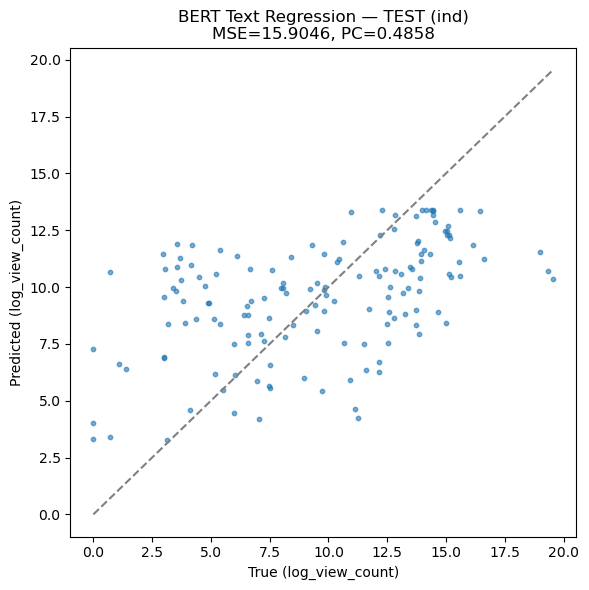

In [19]:
# Person-Independent Split
res_ind = train_from_tv_and_test("ind")


===== [dep] Train+Val -> Test (Text Regression) =====


C:\Users\Mansi Jadhav\AppData\Local\Temp\ipykernel_4464\1859553332.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pt_path, map_location=DEVICE

Best hyper-params (loaded): {'lr': 4.650795575031287e-05, 'weight_decay': 0.0006302314035822081, 'warmup_ratio': 0.05067398569661526, 'dropout': 0.3843006901645646, 'huber_delta': 1.975844353130489, 'target_col': 'log_view_count', 'seed': 42}
train+val: 350 | test: 150
internal train: 300 | internal val: 50
Epoch 01 | Train MSE 3.4276 PC 0.925 || Val MSE 2.4108 PC 0.953
Epoch 02 | Train MSE 3.2650 PC 0.927 || Val MSE 2.6493 PC 0.941
Epoch 03 | Train MSE 2.7311 PC 0.933 || Val MSE 2.1927 PC 0.946
Epoch 04 | Train MSE 1.9701 PC 0.954 || Val MSE 2.3626 PC 0.935
Epoch 05 | Train MSE 1.6756 PC 0.955 || Val MSE 1.7504 PC 0.951
Epoch 06 | Train MSE 1.6367 PC 0.964 || Val MSE 2.2221 PC 0.946
Epoch 07 | Train MSE 1.3672 PC 0.963 || Val MSE 1.9252 PC 0.941
Epoch 08 | Train MSE 1.1664 PC 0.968 || Val MSE 1.6535 PC 0.950
Epoch 09 | Train MSE 1.2769 PC 0.972 || Val MSE 1.9295 PC 0.947
Epoch 10 | Train MSE 0.9604 PC 0.975 || Val MSE 2.1851 PC 0.933
Epoch 11 | Train MSE 0.8566 PC 0.978 || Val MSE 2.6

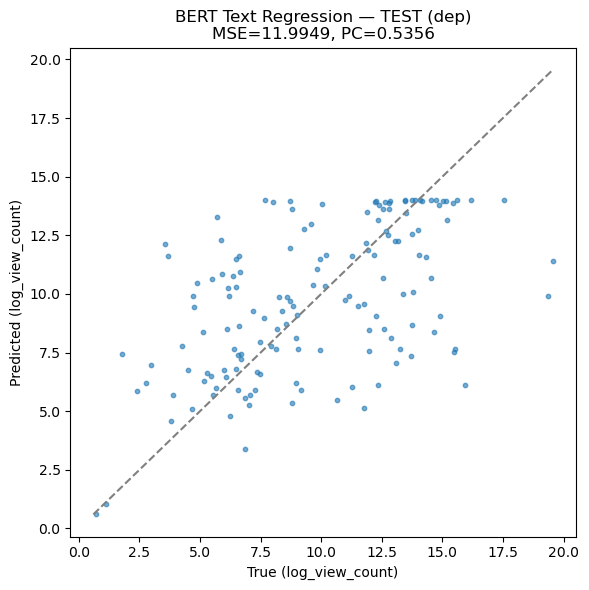

In [20]:
# Person-Dependent Split
res_dep = train_from_tv_and_test("dep")

In [21]:
print("\nFinal:")
print("Person-Independent Split:", res_ind)
print("Person-Dependent Split:", res_dep)


Final:
Person-Independent Split: {'test_mse': 15.904582977294922, 'test_pc': 0.4858127162870822, 'csv': 'results_final\\text_reg_test_ind.csv'}
Person-Dependent Split: {'test_mse': 11.994915008544922, 'test_pc': 0.5356381323246014, 'csv': 'results_final\\text_reg_test_dep.csv'}
